# Preparation Work

In [1]:
#!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 468 (delta 195), reused 213 (delta 131), pack-reused 162 (from 1)
Receiving objects: 100% (468/468), 280.62 KiB | 5.61 MiB/s, done.
Resolving deltas: 100% (236/236), done.


In [1]:
cd /home/yl2672496l/Yue/code/llm/lag-llama

/home/yl2672496l/Yue/code/llm/lag-llama


In [2]:
# import sys
# !{sys.executable} -m pip install -r requirements.txt --quiet

In [3]:
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /home/yl2672496l/Yue/code/llm/lag-llama

In [5]:
# %pip install gluonts==0.14.4

  Using cached gluonts-0.14.4-py3-none-any.whl.metadata (9.5 kB)
Using cached gluonts-0.14.4-py3-none-any.whl (1.5 MB)
  Attempting uninstall: gluonts
    Found existing installation: gluonts 0.15.1
    Uninstalling gluonts-0.15.1:
      Successfully uninstalled gluonts-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-timeseries 1.1.1 requires gluonts==0.15.1, but you have gluonts 0.14.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [27]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

/tmp/ipykernel_852779/45153676.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [28]:
import torch
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

for i in range(num_gpus):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")

Number of GPUs available: 1
GPU 0: NVIDIA A30


In [29]:
if torch.cuda.is_available():
    try:
        for i in range(torch.cuda.device_count()):
            # Set the maximum memory fraction for each GPU
            # For example, 0.5 means 50% of the GPU memory
            torch.cuda.set_per_process_memory_fraction(0.9, device=i)
        print("Memory fraction set for GPUs.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

Memory fraction set for GPUs.


# Lag-Llama prediction function

We create a function for Lag-Llama inference that we can reuse for all different types of dataset below. This function returns the predictions for the given prediction horizon. The forecast will be of shape (`num_samples`, `prediction_length`), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.


In [64]:
def get_lag_llama_predictions(dataset, prediction_length, context_length, num_samples, device, batch_size, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

# Read data

In [65]:
import numpy as np

In [66]:
import os
os.getcwd()

'/home/yl2672496l/Yue/code/llm/lag-llama'

In [67]:
traffic_data = pd.read_csv('../../GD030A_S.csv')

In [68]:
# Define the recover_timestamp function
def recover_timestamp(data):
    # Combine 'date' and 'time' to form a datetime column
    data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'].astype(str) + ':00', format='%Y-%m-%d %H:%M')

    # Set 'datetime' as index
    data = data.set_index('datetime')

    # Create a complete range of timestamps with hourly frequency
    full_time_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')

    # Reindex the data to include all timestamps, filling missing rows with NaN
    data_full = data.reindex(full_time_range)

    return data_full

In [69]:
# Apply the recover_timestamp function to recover the full time series
traffic_full = recover_timestamp(traffic_data)
traffic_full

,date,time,flow
2019-10-01 00:00:00,2019-10-01,0.0,15.0
2019-10-01 01:00:00,2019-10-01,1.0,9.0
2019-10-01 02:00:00,2019-10-01,2.0,9.0
2019-10-01 03:00:00,2019-10-01,3.0,7.0
2019-10-01 04:00:00,2019-10-01,4.0,9.0
...,...,...,...
2023-09-30 19:00:00,2023-09-30,19.0,129.0
2023-09-30 20:00:00,2023-09-30,20.0,119.0
2023-09-30 21:00:00,2023-09-30,21.0,106.0
2023-09-30 22:00:00,2023-09-30,22.0,88.0


In [70]:
train_set = traffic_full['2022-06-03 00:00:00':'2023-03-31 23:00:00']
valid_set = traffic_full['2023-04-01 00:00:00':'2023-06-30 23:00:00']
test_set = traffic_full['2023-07-01 00:00:00':]
# print('Proportion of train_set : {:.4f}'.format(len(train_set)/len(traffic_full['2022-06-03 00:00:00':])))
# print('Proportion of valid_set : {:.4f}'.format(len(valid_set)/len(traffic_full['2022-06-03 00:00:00':])))
# print('Proportion of test_set : {:.4f}'.format(len(test_set)/len(traffic_full['2022-06-03 00:00:00':])))

# train_set = traffic_full[:'2022-02-28 23:00:00']
# valid_set = traffic_full['2022-03-01 00:00:00':'2022-12-31 23:00:00']
# test_set = traffic_full['2023-01-01 00:00:00':]

In [71]:
import pandas as pd
import numpy as np

def create_sequences(data, input_length, forecast_horizon):
    """
    Creates sequences for time series data, excluding any sequences containing NaN values.

    Parameters:
    - data: pandas DataFrame containing the data. Must include the 'flow' column.
    - input_length: int, number of past time steps to include in each input sequence.
    - forecast_horizon: int, number of future steps to predict.

    Returns:
    - sequences_df: pandas DataFrame containing all sequences with input lags and output leads,
                    and an 'item_id' column to separate each sequence.
    """
    sequences = []
    item_id = 0  # To assign unique ID to each sequence

    for i in range(input_length, len(data) - forecast_horizon + 1):
        # Extract the input sequence
        X_seq = data.iloc[i - input_length:i]['flow'].values
        # Extract the target sequence
        y_seq = data.iloc[i:i + forecast_horizon]['flow'].values

        # Check for NaN values in the input sequence and target sequence
        if not np.isnan(X_seq).any() and not np.isnan(y_seq).any():
            # Convert X_seq and y_seq to DataFrames
            x_df = pd.DataFrame({'target_flow': X_seq})
            y_df = pd.DataFrame({'target_flow': y_seq})

            # Concatenate X_df and y_df
            seq_df = pd.concat([x_df, y_df], ignore_index=True)

            # Add 'item_id' column
            seq_df['item_id'] = item_id
            item_id += 1  # Increment item_id

            # Append to list
            sequences.append(seq_df)
        else:
            # Optionally, log or count the skipped sequences
            pass  # Simply skip sequences with NaNs

    # Concatenate all sequences into one DataFrame
    sequences_df = pd.concat(sequences)
    sequences_df['item_id'] = sequences_df['item_id'].astype('object')
    sequences_df['target_flow'] = sequences_df['target_flow'].astype('float32')

    return sequences_df


In [72]:
# Define Input Sequence Lengths
# input_lengths = [32,64,128,256,512]
input_lengths = [24 * i for i in range(1, 22)]

In [73]:
from collections import defaultdict
data_dict = defaultdict(dict)

for length in input_lengths:
    print(f"Processing input length: {length}")

    # Create sequences with forecast_horizon=6
    train = create_sequences(train_set, length, forecast_horizon=6)
    val = create_sequences(valid_set, length, forecast_horizon=6)
    test = create_sequences(test_set, length, forecast_horizon=6)

    # Store in the dictionary
    data_dict[length]['train'] = train
    data_dict[length]['val'] = val
    data_dict[length]['test'] = test

    # Print shapes and ensure no NaNs
    print(f"  train shape: {train.index.max()+1}, {len(train.item_id.unique())}")
    print(f"  val shape: {val.index.max()+1}, {len(val.item_id.unique())}")
    print(f"  test shape: {test.index.max()+1}, {len(test.item_id.unique())}\n")

Processing input length: 24
  train shape: 30, 7145
  val shape: 30, 2007
  test shape: 30, 1719

Processing input length: 48
  train shape: 54, 7073
  val shape: 54, 1911
  test shape: 54, 1604

Processing input length: 72
  train shape: 78, 7001
  val shape: 78, 1815
  test shape: 78, 1508

Processing input length: 96
  train shape: 102, 6929
  val shape: 102, 1719
  test shape: 102, 1412

Processing input length: 120
  train shape: 126, 6857
  val shape: 126, 1623
  test shape: 126, 1316

Processing input length: 144
  train shape: 150, 6785
  val shape: 150, 1527
  test shape: 150, 1220

Processing input length: 168
  train shape: 174, 6713
  val shape: 174, 1431
  test shape: 174, 1124

Processing input length: 192
  train shape: 198, 6641
  val shape: 198, 1335
  test shape: 198, 1028

Processing input length: 216
  train shape: 222, 6569
  val shape: 222, 1239
  test shape: 222, 932

Processing input length: 240
  train shape: 246, 6497
  val shape: 246, 1143
  test shape: 246, 

# Zero-shot

In [74]:
import logging

logging.basicConfig(
    level=logging.INFO,  # Set the logging level to INFO
    format='%(asctime)s - %(message)s',  # Customize the log message format
    handlers=[
        logging.FileHandler('lag_llama.log'),  # Log messages to 'output.log'
        logging.StreamHandler()             # Also output to console/notebook
    ]
)

In [75]:
input_lengths=[24 * i for i in range(1, 22)]
input_lengths

[24,
 48,
 72,
 96,
 120,
 144,
 168,
 192,
 216,
 240,
 264,
 288,
 312,
 336,
 360,
 384,
 408,
 432,
 456,
 480,
 504]

In [77]:
import sys
from contextlib import redirect_stdout, redirect_stderr

results_dict = defaultdict(dict)

with open('lag_llama.log', 'a') as f:  # use 'a' to append to your existing log
    with redirect_stdout(f), redirect_stderr(f):
        for length in input_lengths:
            print(f"Processing input length: {length}")
            
            # Create the Pandas
            dataset_test = PandasDataset.from_long_dataframe(data_dict[length]['test'], target="target_flow", item_id="item_id") 
            
            forecasts, tss = get_lag_llama_predictions(
                dataset=dataset_test,
                prediction_length=6,  # Define your prediction length.
                num_samples=100,      # number of samples sampled from the probability distribution for each timestep
                context_length=length,
                device=torch.device("cuda"), # You can switch this to CPU or other GPUs if you'd like, depending on your environment
                batch_size=32
            )
            
            results_dict[length]['Predicted_Results'] = forecasts
            results_dict[length]['Gound_Truth'] = tss

            torch.cuda.empty_cache()
    
#results_dict

2025-12-03 11:34:19,421 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:36:07,203 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:38:07,386 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:40:32,747 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:43:04,418 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:45:52,846 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:48:44,574 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:51:29,668 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:54:22,887 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:57:08,450 - Grouping data by 'item_id'; this may take some time.
2025-12-03 11:59:45,561 - Grouping data by 'item_id'; this may take some time.
2025-12-03 12:02:24,196 - Grouping data by 'item_id'; this may take some time.
2025-12-03 12:04:47,592 - Grouping data by 'item_id'

In [ ]:
import pickle
with open("../results_dict_lagllama_entire_data.pkl", "wb") as f:
    pickle.dump(results_dict, f)

In [2]:
import pickle
with open("../results_dict_lagllama_entire_data.pkl", "rb") as f:
    results_dict = pickle.load(f)

In [36]:
import numpy as np
import pandas as pd
from tqdm import tqdm

eps = 1e-8  # small value to avoid division by zero in MAPE

def compute_metrics_per_sample(results_dict, show_progress=True):
    """
    Compute MAE, RMSE, MAPE for each input_len, each Monte-Carlo sample (run_num), and each forecast step (pre_step).
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with structure:
        results_dict[input_len]["Predicted_Results"] -> list of SampleForecast (length = num_series)
        results_dict[input_len]["Gound_Truth"] -> list of Pandas DataFrame (length = num_series)
    show_progress : bool
        If True, show tqdm progress bars.
    
    Returns:
    --------
    df : pandas.DataFrame
        Columns: ["input_len", "run_num", "pre_step", "MAE_test", "RMSE_test", "MAPE (%)_test"]
    """
    rows = []

    input_lens = sorted(results_dict.keys())

    for input_len in tqdm(input_lens, desc="input_len", disable=not show_progress):
        preds_list = results_dict[input_len]["Predicted_Results"]
        truths_list = results_dict[input_len]["Gound_Truth"]

        num_series = len(preds_list)
        if num_series == 0:
            continue

        # Determine prediction length and number of Monte-Carlo samples from first forecast
        first_forecast = preds_list[0].samples
        if first_forecast.ndim == 2:
            num_samples, prediction_length = first_forecast.shape
        elif first_forecast.ndim == 3:
            num_samples, prediction_length, _ = first_forecast.shape
        else:
            raise ValueError(f"Unexpected samples shape: {first_forecast.shape}")

        for sample_idx in tqdm(range(num_samples), desc=f"samples (len={input_len})", leave=False, disable=not show_progress):
            for pre_step in range(prediction_length):
                mae_list = []
                rmse_list = []
                mape_list = []

                for series_idx in range(num_series):
                    fc = preds_list[series_idx]
                    gt = truths_list[series_idx]

                    # --- Use only the last `prediction_length` values of ground truth ---
                    truth_values = gt.values.flatten()[-prediction_length:]
                    y_true = truth_values[pre_step]  # scalar
                    y_pred = fc.samples[sample_idx, pre_step]  # scalar

                    # errors
                    err = y_true - y_pred
                    mae_list.append(abs(err))
                    rmse_list.append(err ** 2)
                    mape_list.append(abs(err) / (abs(y_true) + eps) * 100)

                # aggregate across series
                row = {
                    "input_len": input_len,
                    "run_num": sample_idx + 1,
                    "pre_step": pre_step + 1,
                    "MAE_test": float(np.mean(mae_list)),
                    "RMSE_test": float(np.sqrt(np.mean(rmse_list))),
                    "MAPE (%)_test": float(np.mean(mape_list))
                }
                rows.append(row)

    df = pd.DataFrame(rows, columns=["input_len", "run_num", "pre_step", "MAE_test", "RMSE_test", "MAPE (%)_test"])
    return df

In [37]:
df = compute_metrics_per_sample(results_dict, show_progress=True)
df

input_len: 100%|██████████| 21/21 [07:04<00:00, 20.21s/it]          


,input_len,run_num,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,24,1,1,38.922611,55.996306,43.792552
1,24,1,2,53.090385,76.328684,62.765400
2,24,1,3,63.623802,92.689024,82.692312
3,24,1,4,72.051201,103.418747,102.815826
4,24,1,5,78.260597,107.761321,118.258558
...,...,...,...,...,...,...
12595,504,100,2,56.909039,79.029352,88.073848
12596,504,100,3,59.729256,82.375462,94.979912
12597,504,100,4,62.734264,91.156180,102.011786
12598,504,100,5,64.268608,94.071530,102.679549


In [78]:
def cal_eva_metrics(forecasts, tss, input_len):
# Initialize lists to store metrics per time step
    mae_per_timestep, mape_per_timestep, mse_per_timestep = [], [], []
    
    for forecast, truth in zip(forecasts, tss):
        forecast_samples = forecast.samples
        truth_values = truth.values.flatten()[-forecast_samples.shape[1]:]
    
        # Average across all samples for each forecast to get avg_forecast
        avg_forecast = np.median(forecast_samples, axis=0)
    
        # Calculate per time step metrics
        mae_steps = np.abs(avg_forecast - truth_values)
        mape_steps = np.abs((avg_forecast - truth_values) / truth_values) * 100
        mse_steps = (avg_forecast - truth_values) ** 2
    
        # Store results per forecast, then calculate average across all forecasts
        mae_per_timestep.append(mae_steps)
        mape_per_timestep.append(mape_steps)
        mse_per_timestep.append(mse_steps)
    
    # Calculate RMSE across all forecasts and time steps
    mse_per_timestep = np.mean(np.array(mse_per_timestep), axis=0)
    rmse_per_timestep = np.sqrt(mse_per_timestep)  # Square root of averaged MSE
    
    # Convert lists to numpy arrays to compute mean across all forecasts
    mae_per_timestep = np.mean(np.array(mae_per_timestep), axis=0)
    mape_per_timestep = np.mean(np.array(mape_per_timestep), axis=0)
    
    # Print metrics per time step
    df = pd.DataFrame({
        "input_len": input_len,
        "pre_step": list(range(1, 7)),
        "MAE_test": mae_per_timestep,
        "RMSE_test": rmse_per_timestep,
        "MAPE (%)_test": mape_per_timestep
    })
    
    # Overall average metrics across all time steps
    mean_mae = np.mean(mae_per_timestep)
    mean_mape = np.mean(mape_per_timestep)
    mean_mse = np.mean(mse_per_timestep)
    mean_rmse = np.mean(rmse_per_timestep)
    
    print("\nOverall Mean MAE:", mean_mae)
    print("Overall Mean MAPE (%):", mean_mape)
    print("Overall Mean MSE:", mean_mse)
    print("Overall Mean RMSE:", mean_rmse)

    return df


In [60]:
# entire data results
all_dfs = []
for length in input_lengths:
    print(f"Processing input length: {length}")
    
    predict = results_dict[length]['Predicted_Results']
    truth = results_dict[length]['Gound_Truth']
    df_metrics = cal_eva_metrics(predict, truth, length)
    display(df_metrics)
    all_dfs.append(df_metrics)
final_df = pd.concat(all_dfs, ignore_index=True)
final_df
# final_df.to_csv('../all_metrics_lagllama_entire_data.csv', index=False)  

Processing input length: 24

Overall Mean MAE: 48.155132
Overall Mean MAPE (%): 76.890755
Overall Mean MSE: 3827.4697
Overall Mean RMSE: 60.302715


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,24,1,28.263538,38.364986,34.439068
1,24,2,37.536682,49.193115,49.803913
2,24,3,45.074055,57.251854,65.919128
3,24,4,52.807934,65.303642,84.448181
4,24,5,59.456223,72.402390,103.630180
5,24,6,65.792358,79.300301,123.104050


Processing input length: 48

Overall Mean MAE: 48.475998
Overall Mean MAPE (%): 69.54177
Overall Mean MSE: 3981.4695
Overall Mean RMSE: 61.519028


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,48,1,27.912399,38.192616,32.553886
1,48,2,38.042873,50.598808,47.622540
2,48,3,46.255577,59.511612,61.921417
3,48,4,53.730911,67.298401,77.372444
4,48,5,59.912563,73.917503,92.923126
5,48,6,65.001656,79.595207,104.857239


Processing input length: 72

Overall Mean MAE: 45.583057
Overall Mean MAPE (%): 55.66853
Overall Mean MSE: 3721.0066
Overall Mean RMSE: 59.439625


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,72,1,26.546883,36.944492,30.044073
1,72,2,35.849369,48.665905,41.320122
2,72,3,43.555332,57.244675,51.902348
3,72,4,50.251862,64.784363,61.498493
4,72,5,56.110928,71.453033,70.675056
5,72,6,61.183964,77.545280,78.571091


Processing input length: 96

Overall Mean MAE: 43.014767
Overall Mean MAPE (%): 54.499527
Overall Mean MSE: 3348.2578
Overall Mean RMSE: 56.767994


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,96,1,26.797920,37.406158,30.794710
1,96,2,35.409641,48.446484,42.834053
2,96,3,41.971382,55.959602,52.379406
3,96,4,47.239735,61.781261,60.163448
4,96,5,51.429050,66.459564,67.471870
5,96,6,55.240871,70.554863,73.353661


Processing input length: 120

Overall Mean MAE: 43.9859
Overall Mean MAPE (%): 52.750763
Overall Mean MSE: 3480.0742
Overall Mean RMSE: 57.72743


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,120,1,26.327747,36.550472,31.439821
1,120,2,35.866886,48.817326,43.765617
2,120,3,43.148895,56.897068,51.599659
3,120,4,49.056770,63.439941,58.571217
4,120,5,53.184402,68.473717,63.801643
5,120,6,56.330692,72.186035,67.326622


Processing input length: 144

Overall Mean MAE: 39.840954
Overall Mean MAPE (%): 51.733967
Overall Mean MSE: 2910.3484
Overall Mean RMSE: 53.064026


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,144,1,25.651556,35.975018,30.762087
1,144,2,33.467419,46.146446,42.190632
2,144,3,39.257526,52.496330,50.368172
3,144,4,43.698498,57.523277,57.395699
4,144,5,47.151661,61.549152,63.148426
5,144,6,49.819069,64.693924,66.538811


Processing input length: 168

Overall Mean MAE: 33.963825
Overall Mean MAPE (%): 55.7634
Overall Mean MSE: 2180.0657
Overall Mean RMSE: 46.229954


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,168,1,24.719534,34.364586,33.836342
1,168,2,30.293299,41.884441,46.118748
2,168,3,34.071796,46.160538,54.883041
3,168,4,36.703213,49.455074,62.011635
4,168,5,38.465248,51.796772,67.246269
5,168,6,39.529873,53.718315,70.484367


Processing input length: 192

Overall Mean MAE: 33.507767
Overall Mean MAPE (%): 47.44782
Overall Mean MSE: 2230.715
Overall Mean RMSE: 46.75601


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,192,1,24.299250,34.473549,29.242092
1,192,2,29.996777,42.478477,39.292736
2,192,3,33.662609,46.883507,46.925842
3,192,4,36.072929,50.157841,52.649902
4,192,5,37.842010,52.296314,56.816895
5,192,6,39.173038,54.246361,59.759449


Processing input length: 216

Overall Mean MAE: 33.713394
Overall Mean MAPE (%): 48.03105
Overall Mean MSE: 2266.3367
Overall Mean RMSE: 47.125294


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,216,1,24.398565,34.636703,30.109938
1,216,2,30.420952,42.757065,40.002827
2,216,3,34.007488,47.509636,47.728706
3,216,4,36.425846,50.638256,52.997749
4,216,5,37.862064,52.670040,57.224220
5,216,6,39.165443,54.540073,60.122860


Processing input length: 240

Overall Mean MAE: 33.84737
Overall Mean MAPE (%): 48.598766
Overall Mean MSE: 2310.2842
Overall Mean RMSE: 47.59462


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,240,1,24.633318,35.035103,30.675934
1,240,2,30.728712,43.451275,41.293224
2,240,3,34.124027,47.993839,47.861759
3,240,4,36.324970,51.044724,53.138416
4,240,5,38.186264,53.455715,58.176983
5,240,6,39.086952,54.587059,60.446262


Processing input length: 264

Overall Mean MAE: 34.20273
Overall Mean MAPE (%): 48.80952
Overall Mean MSE: 2355.4302
Overall Mean RMSE: 48.06862


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,264,1,25.058573,35.510002,30.975182
1,264,2,30.995211,43.847675,41.403500
2,264,3,34.870110,48.660328,49.190376
3,264,4,36.909275,51.704868,54.035004
4,264,5,38.177483,53.586700,57.572865
5,264,6,39.205723,55.102154,59.680176


Processing input length: 288

Overall Mean MAE: 34.45684
Overall Mean MAPE (%): 49.497173
Overall Mean MSE: 2406.0874
Overall Mean RMSE: 48.59157


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,288,1,25.171743,35.708027,31.581438
1,288,2,31.646273,44.827351,42.541683
2,288,3,35.017422,49.420231,49.427387
3,288,4,37.091015,52.160545,54.661682
4,288,5,38.321362,53.986771,57.875668
5,288,6,39.493225,55.446526,60.895184


Processing input length: 312

Overall Mean MAE: 34.838642
Overall Mean MAPE (%): 51.154755
Overall Mean MSE: 2445.0964
Overall Mean RMSE: 48.981052


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,312,1,25.448999,35.915310,32.602234
1,312,2,31.897657,45.205780,44.262821
2,312,3,35.589504,49.962189,51.699596
3,312,4,37.407253,52.416428,56.651810
4,312,5,39.013485,54.559937,59.720413
5,312,6,39.674938,55.826668,61.991650


Processing input length: 336

Overall Mean MAE: 32.954075
Overall Mean MAPE (%): 57.064137
Overall Mean MSE: 2228.2168
Overall Mean RMSE: 46.860184


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,336,1,25.419518,35.773079,37.052334
1,336,2,30.905664,43.921665,50.586956
2,336,3,33.587467,47.692661,58.526295
3,336,4,35.088673,49.791409,63.082306
4,336,5,36.098835,51.469727,65.659004
5,336,6,36.624298,52.512550,67.477928


Processing input length: 360

Overall Mean MAE: 32.937813
Overall Mean MAPE (%): 53.45402
Overall Mean MSE: 2299.6826
Overall Mean RMSE: 47.573425


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,360,1,25.302036,35.760872,35.218056
1,360,2,30.949966,44.493721,47.878113
2,360,3,33.638840,48.342209,55.268730
3,360,4,35.279869,51.044159,58.646206
4,360,5,36.164581,52.504955,61.135361
5,360,6,36.291576,53.294643,62.577625


Processing input length: 384

Overall Mean MAE: 32.67196
Overall Mean MAPE (%): 51.40921
Overall Mean MSE: 2329.7075
Overall Mean RMSE: 47.895985


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,384,1,25.329424,36.157650,34.258205
1,384,2,30.765768,44.809231,46.824024
2,384,3,33.354038,49.001255,52.918018
3,384,4,34.775860,51.190266,56.257950
4,384,5,35.722092,52.687225,58.744221
5,384,6,36.084564,53.530296,59.452866


Processing input length: 408

Overall Mean MAE: 33.259243
Overall Mean MAPE (%): 50.66057
Overall Mean MSE: 2422.5798
Overall Mean RMSE: 48.821438


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,408,1,25.554457,36.522491,34.070541
1,408,2,31.346739,45.808064,45.728767
2,408,3,33.854218,49.656662,51.687866
3,408,4,35.392689,52.207638,55.123425
4,408,5,36.536343,53.997452,57.921124
5,408,6,36.871021,54.736301,59.431683


Processing input length: 432

Overall Mean MAE: 33.583973
Overall Mean MAPE (%): 50.46872
Overall Mean MSE: 2469.3462
Overall Mean RMSE: 49.283802


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,432,1,25.616648,36.752728,33.959370
1,432,2,31.623102,46.175636,45.690422
2,432,3,34.195969,50.328457,51.465061
3,432,4,35.728981,52.707939,54.782219
4,432,5,36.794037,54.227348,57.452213
5,432,6,37.545090,55.510708,59.463047


Processing input length: 456

Overall Mean MAE: 33.487316
Overall Mean MAPE (%): 51.20572
Overall Mean MSE: 2407.9905
Overall Mean RMSE: 48.707623


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,456,1,25.853800,36.959400,34.968239
1,456,2,31.570328,45.586414,46.669605
2,456,3,34.277271,49.978172,52.116852
3,456,4,35.594933,52.139236,55.471298
4,456,5,36.521473,53.285728,58.047188
5,456,6,37.106098,54.296768,59.961105


Processing input length: 480

Overall Mean MAE: 33.270527
Overall Mean MAPE (%): 51.474503
Overall Mean MSE: 2373.803
Overall Mean RMSE: 48.363087


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,480,1,25.694248,36.767849,35.018642
1,480,2,31.465206,45.367573,45.779148
2,480,3,33.878578,49.219074,52.878204
3,480,4,35.448620,51.917400,55.996754
4,480,5,36.294983,53.079346,58.400677
5,480,6,36.841518,53.827278,60.773582


Processing input length: 504

Overall Mean MAE: 32.397663
Overall Mean MAPE (%): 56.258556
Overall Mean MSE: 2221.533
Overall Mean RMSE: 46.785538


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,504,1,25.317026,35.540997,37.595005
1,504,2,30.755737,43.890308,50.917419
2,504,3,33.185616,47.812443,57.506901
3,504,4,34.380463,49.956326,61.687313
4,504,5,35.118534,51.244232,64.146645
5,504,6,35.628613,52.268929,65.698067


In [ ]:
# after COVID-19 results
all_dfs = []
for length in input_lengths:
    print(f"Processing input length: {length}")
    
    predict = results_dict[length]['Predicted_Results']
    truth = results_dict[length]['Gound_Truth']
    df_metrics = cal_eva_metrics(predict, truth, length)
    display(df_metrics)
    all_dfs.append(df_metrics)
final_df = pd.concat(all_dfs, ignore_index=True)
final_df
final_df.to_csv('../all_metrics_lagllama_after_covid.csv', index=False)  

Processing input length: 24

Overall Mean MAE: 38.66801
Overall Mean MAPE (%): 40.43149
Overall Mean MSE: 2311.6096
Overall Mean RMSE: 46.914997


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,24,1,24.204754,30.287971,23.301537
1,24,2,31.247801,38.480450,30.898872
2,24,3,36.476086,44.391426,37.552639
3,24,4,42.187305,50.801327,44.840233
4,24,5,46.787788,56.150471,49.805073
5,24,6,51.104336,61.378357,56.190605


Processing input length: 48

Overall Mean MAE: 39.48926
Overall Mean MAPE (%): 39.746765
Overall Mean MSE: 2473.3809
Overall Mean RMSE: 48.40437


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,48,1,23.500288,29.238646,22.061852
1,48,2,31.928129,39.485504,30.990700
2,48,3,37.433838,46.861725,37.552021
3,48,4,43.475136,53.651367,43.981461
4,48,5,48.288036,58.544098,49.593437
5,48,6,52.310120,62.644867,54.301113


Processing input length: 72

Overall Mean MAE: 34.755726
Overall Mean MAPE (%): 30.858917
Overall Mean MSE: 1939.0826
Overall Mean RMSE: 43.02293


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,72,1,21.333128,27.287497,18.957994
1,72,2,28.429817,35.960842,25.531820
2,72,3,33.141533,41.735317,29.237877
3,72,4,37.783913,46.734295,33.435505
4,72,5,42.203411,51.183971,37.369320
5,72,6,45.642567,55.235645,40.620991


Processing input length: 96

Overall Mean MAE: 32.63814
Overall Mean MAPE (%): 30.117859
Overall Mean MSE: 1766.2599
Overall Mean RMSE: 41.313335


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,96,1,21.573238,27.716515,19.121212
1,96,2,27.747597,35.819923,25.005768
2,96,3,31.599672,41.016087,29.177582
3,96,4,35.495224,44.815735,32.926929
4,96,5,38.403778,47.983925,35.830635
5,96,6,41.009323,50.527832,38.645027


Processing input length: 120

Overall Mean MAE: 33.750076
Overall Mean MAPE (%): 28.15061
Overall Mean MSE: 1840.5166
Overall Mean RMSE: 41.962032


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,120,1,20.764076,26.356459,18.462723
1,120,2,27.787588,35.457756,24.279493
2,120,3,33.258808,41.537418,28.102047
3,120,4,37.269020,46.002296,30.870821
4,120,5,40.584873,49.648895,33.109875
5,120,6,42.836090,52.769348,34.078690


Processing input length: 144

Overall Mean MAE: 30.22436
Overall Mean MAPE (%): 26.084108
Overall Mean MSE: 1476.5316
Overall Mean RMSE: 37.806164


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,144,1,20.335119,25.876360,17.705143
1,144,2,25.600103,33.044819,22.521559
2,144,3,29.462500,37.130844,25.785320
3,144,4,32.694927,40.648815,28.229866
4,144,5,35.407867,43.592575,30.206169
5,144,6,37.845642,46.543571,32.056595


Processing input length: 168

Overall Mean MAE: 26.232908
Overall Mean MAPE (%): 24.983261
Overall Mean MSE: 1065.483
Overall Mean RMSE: 32.314342


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,168,1,19.163977,24.163647,17.080196
1,168,2,22.822315,28.896963,21.583952
2,168,3,26.149435,32.138371,25.132185
3,168,4,28.632530,34.962337,27.557537
4,168,5,29.618261,36.129585,28.708399
5,168,6,31.010923,37.595150,29.837296


Processing input length: 192

Overall Mean MAE: 24.5204
Overall Mean MAPE (%): 21.379293
Overall Mean MSE: 967.4821
Overall Mean RMSE: 30.8152


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,192,1,18.266230,23.302595,15.255915
1,192,2,21.516247,27.735758,18.716017
2,192,3,24.302361,30.659674,21.380194
3,192,4,26.425858,33.042664,23.343060
4,192,5,28.003021,34.736919,24.674849
5,192,6,28.608673,35.413597,24.905714


Processing input length: 216

Overall Mean MAE: 24.944643
Overall Mean MAPE (%): 20.83898
Overall Mean MSE: 1000.31085
Overall Mean RMSE: 31.313581


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,216,1,17.997986,23.158411,14.757759
1,216,2,22.090902,28.368662,18.386185
2,216,3,25.153179,31.462250,21.169285
3,216,4,26.869642,33.556004,22.486111
4,216,5,28.466322,35.183937,23.893614
5,216,6,29.089825,36.152237,24.340927


Processing input length: 240

Overall Mean MAE: 24.86247
Overall Mean MAPE (%): 20.377234
Overall Mean MSE: 997.153
Overall Mean RMSE: 31.258718


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,240,1,17.858795,22.882126,14.396510
1,240,2,22.491220,28.546169,18.581009
2,240,3,24.917961,31.399832,20.627157
3,240,4,26.823385,33.679909,21.903757
4,240,5,28.334585,35.015755,23.210100
5,240,6,28.748877,36.028511,23.544876


Processing input length: 264

Overall Mean MAE: 25.517944
Overall Mean MAPE (%): 19.599035
Overall Mean MSE: 1067.2123
Overall Mean RMSE: 32.3093


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,264,1,17.763638,22.996939,13.749767
1,264,2,23.003817,29.629066,17.841536
2,264,3,26.087606,32.950207,20.125408
3,264,4,27.700394,34.891521,21.388302
4,264,5,28.826889,36.196980,21.916855
5,264,6,29.725325,37.191086,22.572340


Processing input length: 288

Overall Mean MAE: 25.795898
Overall Mean MAPE (%): 19.631205
Overall Mean MSE: 1067.922
Overall Mean RMSE: 32.38425


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,288,1,18.861151,23.967138,14.407691
1,288,2,23.630594,29.940289,18.061413
2,288,3,26.162199,32.806313,19.914085
3,288,4,27.795872,34.795338,21.100967
4,288,5,29.064497,36.229092,22.101665
5,288,6,29.261070,36.567341,22.201391


Processing input length: 312

Overall Mean MAE: 25.499441
Overall Mean MAPE (%): 19.515568
Overall Mean MSE: 1051.868
Overall Mean RMSE: 32.166615


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,312,1,18.996853,24.155516,14.490822
1,312,2,23.389465,29.768145,18.088413
2,312,3,25.943357,32.787994,19.782534
3,312,4,27.852180,34.845531,21.309874
4,312,5,28.106468,35.335999,21.519257
5,312,6,28.708323,36.106506,21.902502


Processing input length: 336

Overall Mean MAE: 21.988485
Overall Mean MAPE (%): 19.818903
Overall Mean MSE: 737.32275
Overall Mean RMSE: 27.061453


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,336,1,18.313581,22.658701,15.592005
1,336,2,21.142481,26.029593,19.023811
2,336,3,22.504347,27.378603,20.383112
3,336,4,23.059013,28.289635,20.978962
4,336,5,23.296537,28.568718,21.278975
5,336,6,23.614939,29.443460,21.656555


Processing input length: 360

Overall Mean MAE: 21.344572
Overall Mean MAPE (%): 18.143951
Overall Mean MSE: 703.51373
Overall Mean RMSE: 26.40236


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,360,1,17.267462,21.521364,14.483603
1,360,2,20.082365,24.704247,17.317205
2,360,3,22.171577,27.173891,19.273943
3,360,4,23.088211,28.432217,19.627647
4,360,5,22.938902,28.378523,19.408848
5,360,6,22.518911,28.203932,18.752457


Processing input length: 384

Overall Mean MAE: 20.218134
Overall Mean MAPE (%): 16.905262
Overall Mean MSE: 651.0132
Overall Mean RMSE: 25.405457


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,384,1,16.339596,20.646507,13.211857
1,384,2,19.353193,24.497284,15.947560
2,384,3,20.368132,25.620514,17.036470
3,384,4,21.697466,27.093822,18.331905
4,384,5,21.859114,27.333157,18.506689
5,384,6,21.691311,27.241451,18.397095


Processing input length: 408

Overall Mean MAE: 20.273737
Overall Mean MAPE (%): 16.591629
Overall Mean MSE: 655.7944
Overall Mean RMSE: 25.514786


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,408,1,16.768978,21.110441,13.430879
1,408,2,19.094082,24.528601,15.645830
2,408,3,20.693935,26.037455,16.938780
3,408,4,21.734818,27.235775,17.827259
4,408,5,21.486048,26.784920,17.719547
5,408,6,21.864563,27.391514,17.987482


Processing input length: 432

Overall Mean MAE: 20.482838
Overall Mean MAPE (%): 16.532219
Overall Mean MSE: 673.7251
Overall Mean RMSE: 25.854332


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,432,1,16.827000,21.326880,13.253816
1,432,2,19.488920,24.690706,15.734865
2,432,3,20.990223,26.257393,16.958963
3,432,4,21.515976,27.285633,17.474434
4,432,5,21.958296,27.489607,17.883625
5,432,6,22.116615,28.075769,17.887608


Processing input length: 456

Overall Mean MAE: 20.541468
Overall Mean MAPE (%): 16.326311
Overall Mean MSE: 691.1638
Overall Mean RMSE: 26.192965


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,456,1,16.837782,21.644461,13.256563
1,456,2,20.002903,25.398642,16.248596
2,456,3,20.764292,26.383112,16.610796
3,456,4,21.657742,27.454098,17.334900
4,456,5,21.816618,28.005772,17.155472
5,456,6,22.169479,28.271715,17.351549


Processing input length: 480

Overall Mean MAE: 19.526896
Overall Mean MAPE (%): 15.674701
Overall Mean MSE: 620.8117
Overall Mean RMSE: 24.829046


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,480,1,15.909833,20.520845,12.655441
1,480,2,19.255878,24.353140,15.605559
2,480,3,19.906610,25.132360,16.075710
3,480,4,20.349632,25.820730,16.403088
4,480,5,21.026777,26.700581,16.713856
5,480,6,20.712645,26.446611,16.594543


Processing input length: 504

Overall Mean MAE: 17.55443
Overall Mean MAPE (%): 15.559097
Overall Mean MSE: 490.29245
Overall Mean RMSE: 22.093956


,input_len,pre_step,MAE_test,RMSE_test,MAPE (%)_test
0,504,1,15.253857,18.958479,13.395021
1,504,2,17.621714,21.902637,15.764594
2,504,3,18.069244,23.027193,16.104208
3,504,4,17.609358,22.489117,15.654671
4,504,5,18.565514,23.148632,16.455877
5,504,6,18.206898,23.037668,15.980213


In [22]:
torch.cuda.empty_cache()

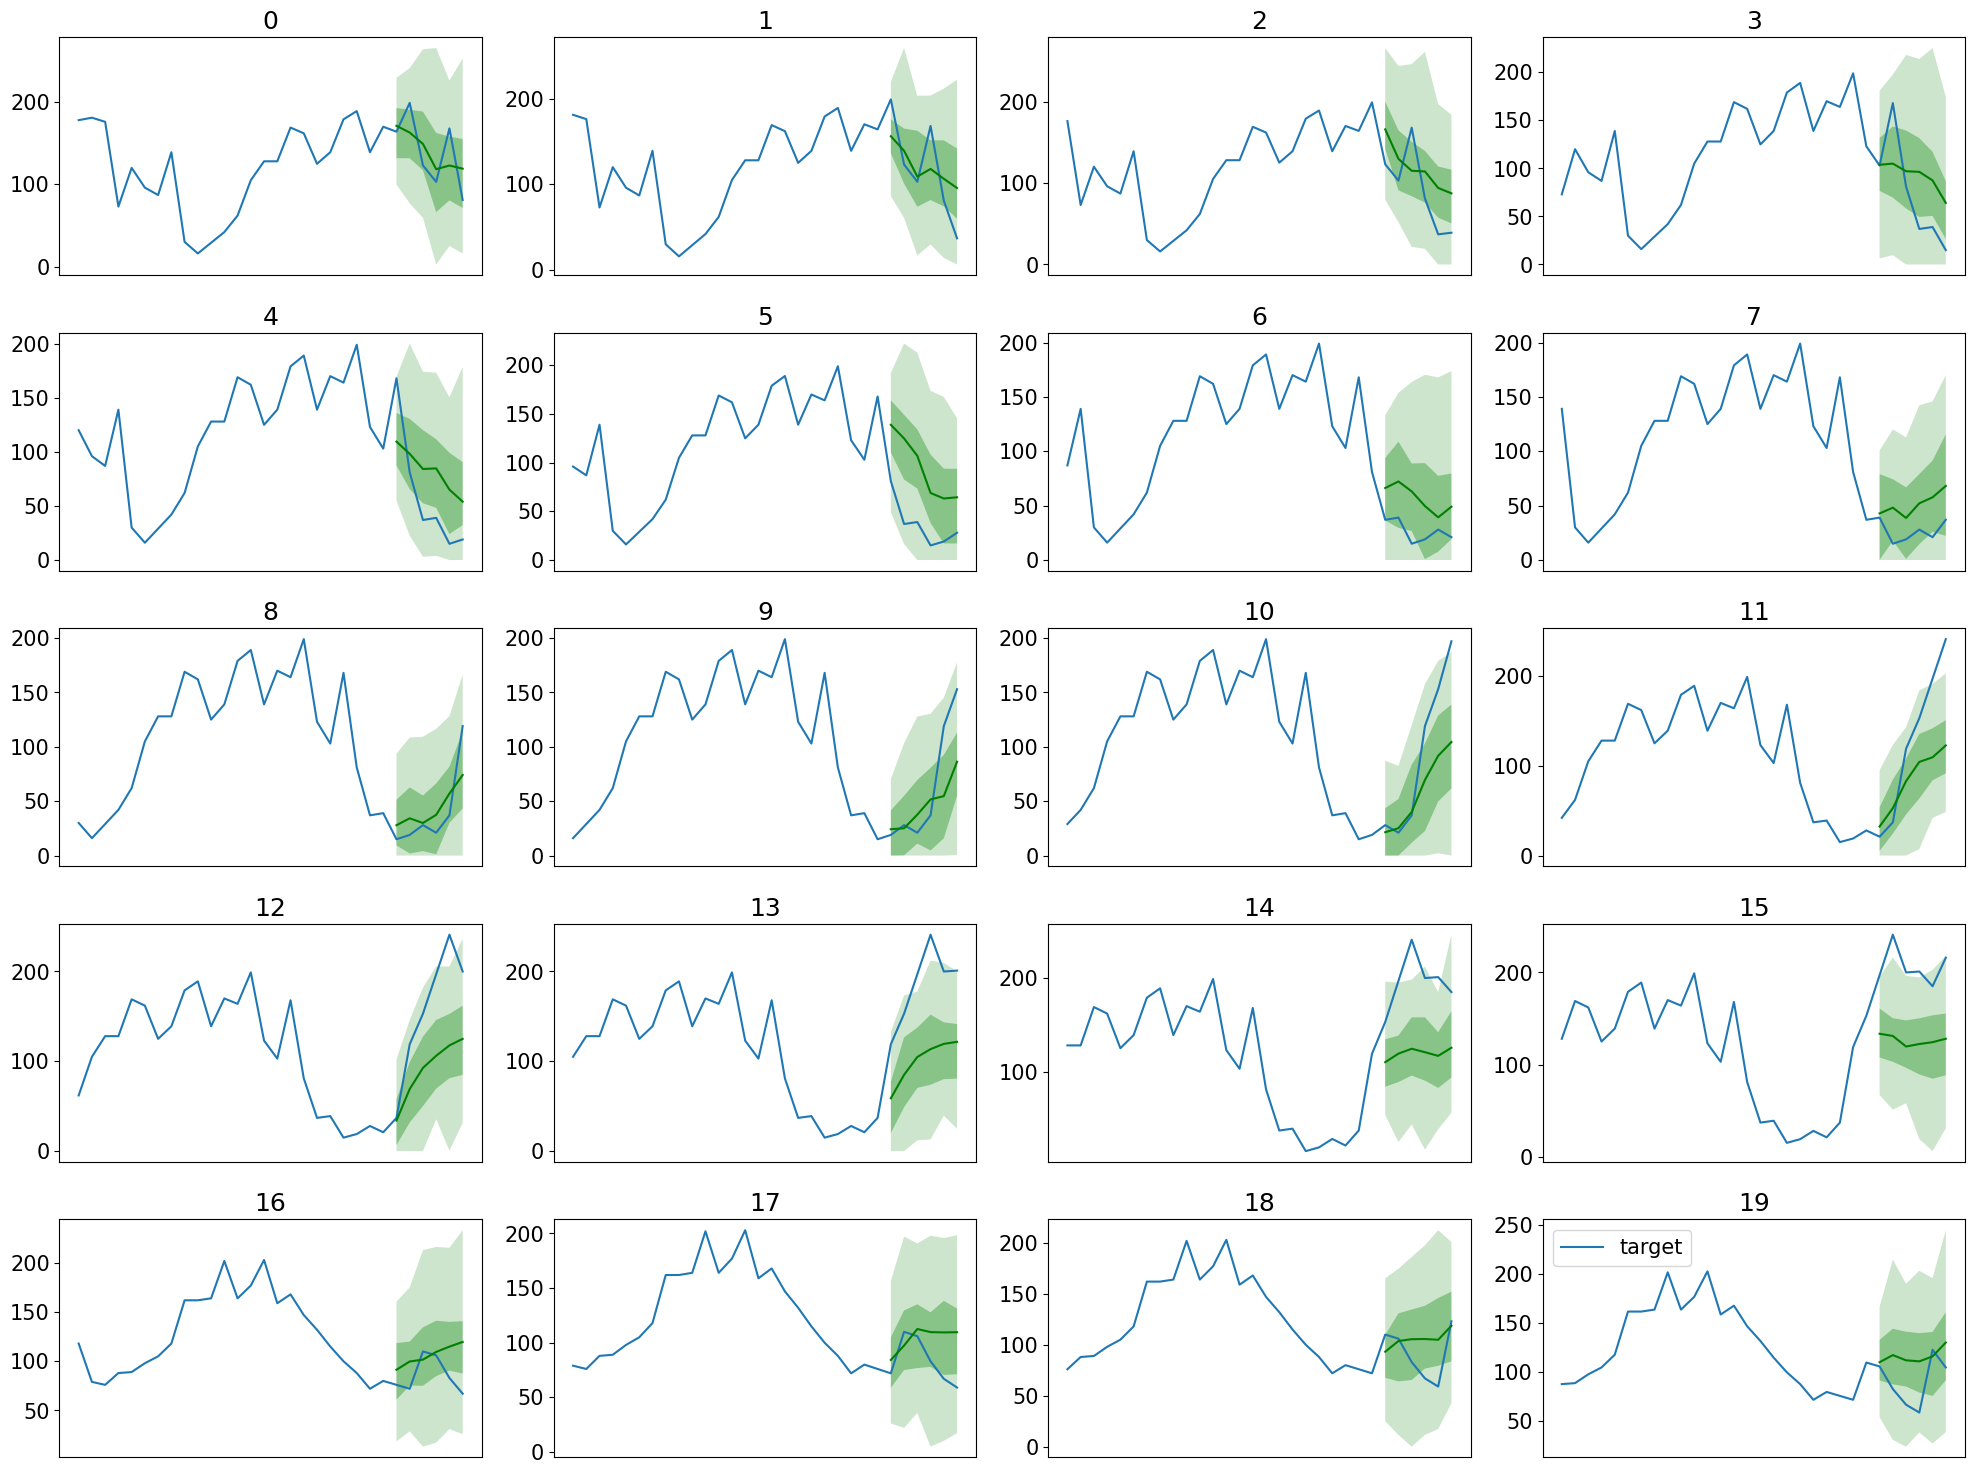

In [84]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 20):
    ax = plt.subplot(5, 4, idx+1)

    plt.plot(ts[-5 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [85]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 772it [00:00, 1590.23it/s]
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` t

| length | MAPE    | sMAPE    | MSE       | RMSE    | MAE_Coverage |
|--------|---------|----------|-----------|---------|--------------|
| 32     | 0.3796  | 0.3143   | 2493.5060 | 49.9350 | 0.3516       |
| 64     | 0.3261  | 0.2985   | 2131.2304 | 46.1652 | 0.3653       |
| 128    | 0.2758  | 0.2730   | 1770.5785 | 42.0782 | 0.3824       |
| 256    | 0.2051  | 0.1973   | 982.9911  | 31.3526 | 0.4542       |

In [86]:
agg_metrics

{'MSE': 982.9911003639867,
 'abs_error': 117112.06209564209,
 'abs_target_sum': 634229.0,
 'abs_target_mean': 136.9233592400691,
 'seasonal_error': 20.62159910596363,
 'MASE': 1.2270170348666125,
 'MAPE': 0.20510673378827454,
 'sMAPE': 0.19732061389428346,
 'MSIS': 12.735467129511218,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 70719.43195877076,
 'Coverage[0.1]': 0.0006476683937823834,
 'QuantileLoss[0.2]': 96311.52169036865,
 'Coverage[0.2]': 0.03324697754749568,
 'QuantileLoss[0.3]': 108290.56922073365,
 'Coverage[0.3]': 0.12629533678756477,
 'QuantileLoss[0.4]': 114864.66205444335,
 'Coverage[0.4]': 0.26813471502590674,
 'QuantileLoss[0.5]': 117112.06193161011,
 'Coverage[0.5]': 0.42033678756476683,
 'QuantileLoss[0.6]': 113936.14461364746,
 'Coverage[0.6]': 0.5494386873920553,
 'QuantileLoss[0.7]': 103519.10407104492,
 'Coverage[0.7]': 0.6949481865284974,
 'QuantileLoss[0.8]': 86696.88474426267,
 'Coverage[0.8]': 0.836139896373057,
 'QuantileLoss[0.9]': 62321.170505523

# Fine-tuning

In [89]:
# Create the Pandas
dataset_train = PandasDataset.from_long_dataframe(data_dict[256]['train'], target="target_flow", item_id="item_id")
dataset_test = PandasDataset.from_long_dataframe(data_dict[256]['test'], target="target_flow", item_id="item_id")
context_length = 256
prediction_length = 6  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda") 

In [23]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device("cuda"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [ ]:
tuning_dict = defaultdict(dict)

for length in input_lengths:
    print(f"Processing input length: {length}")
    
    # Create the Pandas
    dataset_test = PandasDataset.from_long_dataframe(data_dict[length]['test'], target="target_flow", item_id="item_id")
    dataset_train = PandasDataset.from_long_dataframe(data_dict[length]['train'], target="target_flow", item_id="item_id")
    
    context_length = length
    prediction_length = 6  # Define your prediction length. We use 24 here since the data is of hourly frequency
    num_samples = 100 # number of samples sampled from the probability distribution for each timestep
    device = torch.device("cuda")
    batch_size=32

    estimator = LagLlamaEstimator(
            ckpt_path="lag-llama.ckpt",
            prediction_length=prediction_length,
            context_length=context_length,
    
            distr_output="neg_bin",
            scaling="mean",
            nonnegative_pred_samples=True,
            aug_prob=0,
            lr=5e-4,
    
            # estimator args
            input_size=estimator_args["input_size"],
            n_layer=estimator_args["n_layer"],
            n_embd_per_head=estimator_args["n_embd_per_head"],
            n_head=estimator_args["n_head"],
            time_feat=estimator_args["time_feat"],
    
            rope_scaling={
                "type": "linear",
                "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
            },
    
            batch_size=batch_size,
            num_parallel_samples=num_samples,
            trainer_kwargs = {"max_epochs": 100,}, # <- lightning trainer arguments
        )
    
    predictor = estimator.train(dataset_train, cache_data=True, shuffle_buffer_length=1000)
    forecast_it, ts_it = make_evaluation_predictions(
            dataset=dataset_test,
            predictor=predictor,
            num_samples=num_samples)
    
    forecasts = list(tqdm(forecast_it, total=len(dataset_test), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset_test), desc="Ground truth"))   
    
    tuning_dict[length]['Predicted_Results'] = forecasts
    tuning_dict[length]['Gound_Truth'] = tss
    
tuning_dict

In [25]:
for length in input_lengths:
    print(f"Processing input length: {length}")
    
    predict_tuning = tuning_dict[length]['Predicted_Results']
    truth_tuning = tuning_dict[length]['Gound_Truth']
    cal_eva_metrics(predict_tuning, truth_tuning)

Processing input length: 24
MAE per time step: [23.857227 29.189602 32.553932 35.225697 38.10465  40.729416]
MAPE per time step (%): [23.49834  27.940311 30.703445 32.793907 35.231194 37.25442 ]
MSE per time step: [1253.7094 1867.0531 2317.4658 2689.43   3121.9841 3585.9229]
RMSE per time step: [35.407757 43.20941  48.140064 51.859715 55.874718 59.882576]

Overall Mean MAE: 33.276752
Overall Mean MAPE (%): 31.236938
Overall Mean MSE: 2472.5942
Overall Mean RMSE: 49.062374
Processing input length: 48
MAE per time step: [24.360859 29.437063 32.8084   35.77968  38.702427 41.114613]
MAPE per time step (%): [23.762291 28.318653 31.47522  34.51269  37.87022  39.94901 ]
MSE per time step: [1273.091  1835.019  2264.254  2644.7236 3022.6655 3419.724 ]
RMSE per time step: [35.6804   42.837124 47.58418  51.426876 54.978775 58.47841 ]

Overall Mean MAE: 33.700504
Overall Mean MAPE (%): 32.648014
Overall Mean MSE: 2409.9128
Overall Mean RMSE: 48.49763
Processing input length: 72
MAE per time step: 

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 20):
    ax = plt.subplot(5, 4, idx+1)

    plt.plot(ts[-5 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

| length | MAPE    | sMAPE    | MSE       | RMSE    | MAE_Coverage |
|--------|---------|----------|-----------|---------|--------------|
| 32     | 0.3338  | 0.4437   | 2534.0593 | 50.3394 | 0.2313       |
| 64     | 0.3218  | 0.4210   | 2312.8289 | 48.0918 | 0.2267       |
| 128    | 0.2339  | 0.2584   | 1369.3422 | 37.0046 | 0.2637       |
| 256    | 0.2400  | 0.2771   | 1588.6067 | 39.8573 | 0.2492       |

In [ ]:
agg_metrics